# 🤖 RL-Based Recommendation: PPO vs DQN vs Bandit (Cold-Start Scenario)

This notebook compares three reinforcement learning-based recommendation strategies in a simulated cold-start environment:
- 🎲 Bandit (Epsilon-Greedy)
- 🧠 DQN (Deep Q-Network)
- 🧠 PPO (Proximal Policy Optimization)

We'll simulate user interactions and track performance over time.


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 调用
set_seed(42)


In [3]:
class ColdStartUser:
    def __init__(self, latent_dim=10):
        self.preference = np.random.rand(latent_dim)

    def respond(self, doc):
        score = np.dot(self.preference, doc)
        return 1 if random.random() < 1 / (1 + np.exp(-score)) else 0

class RecSimEnv:
    def __init__(self, num_docs=20, latent_dim=10):
        self.latent_dim = latent_dim
        self.docs = [np.random.rand(latent_dim) for _ in range(num_docs)]
        self.user = ColdStartUser(latent_dim)
        self.num_docs = num_docs

    def step(self, action):
        doc = self.docs[action]
        reward = self.user.respond(doc)
        return doc, reward


In [4]:
class EpsilonGreedyAgent:
    def __init__(self, n_arms, epsilon=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.values = np.zeros(n_arms)
        self.counts = np.zeros(n_arms)

    def act(self):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_arms - 1)
        return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        alpha = 1 / self.counts[arm]
        self.values[arm] += alpha * (reward - self.values[arm])


In [5]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, input_dim, n_actions):
        self.q_net = QNetwork(input_dim, n_actions)
        self.target_net = QNetwork(input_dim, n_actions)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.memory = deque(maxlen=1000)
        self.gamma = 0.95
        self.batch_size = 32
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=0.001)
        self.n_actions = n_actions
        self.epsilon = 0.1

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        with torch.no_grad():
            q_vals = self.q_net(torch.FloatTensor(state).unsqueeze(0))
            return int(torch.argmax(q_vals).item())

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)

        q_vals = self.q_net(states).gather(1, actions).squeeze()
        next_q_vals = self.target_net(next_states).max(1)[0].detach()
        targets = rewards + self.gamma * next_q_vals

        loss = nn.MSELoss()(q_vals, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [6]:
class PPOActor(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)

class PPOCritic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

class PPOAgent:
    def __init__(self, input_dim, n_actions):
        self.actor = PPOActor(input_dim, n_actions)
        self.critic = PPOCritic(input_dim)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=0.002)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=0.002)
        self.gamma = 0.99
        self.clip_eps = 0.2
        self.memory = []

    def act(self, state):
        state_tensor = torch.FloatTensor(state)
        probs = self.actor(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def store(self, transition):
        self.memory.append(transition)

    def update(self):
        states, actions, rewards, next_states, log_probs = zip(*self.memory)
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        old_log_probs = torch.stack(log_probs)

        values = self.critic(states).squeeze()
        next_values = self.critic(next_states).squeeze()
        returns = rewards + self.gamma * next_values.detach()
        advantages = returns - values.detach()

        for _ in range(3):
            new_probs = self.actor(states)
            dist = torch.distributions.Categorical(new_probs)
            new_log_probs = dist.log_prob(actions)

            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()

            critic_loss = nn.MSELoss()(self.critic(states).squeeze(), returns.detach())

            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()

            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()

        self.memory = []


C:\Users\liuzu\AppData\Local\Temp\ipykernel_56136\2292836666.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.FloatTensor(states)
C:\Users\liuzu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


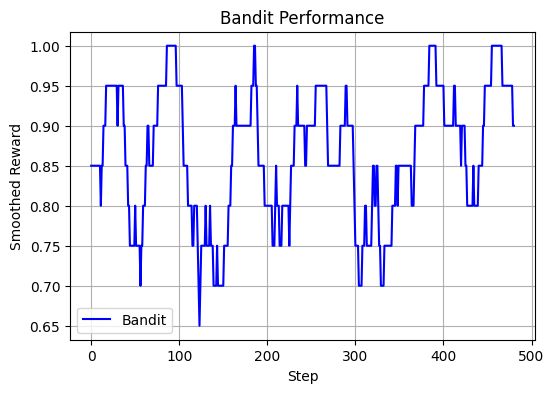

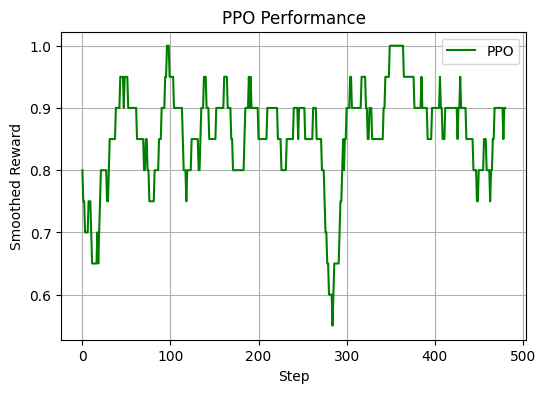

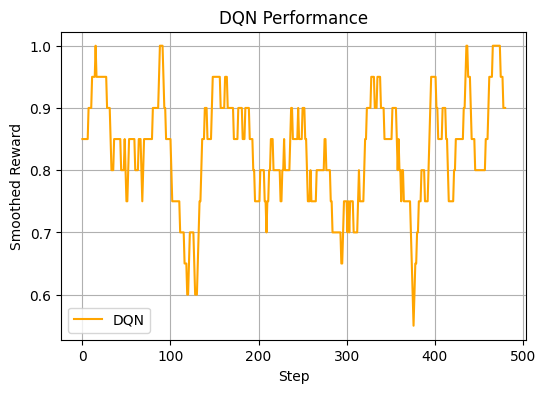

In [7]:
env = RecSimEnv()
bandit = EpsilonGreedyAgent(n_arms=env.num_docs)
dqn = DQNAgent(input_dim=env.latent_dim, n_actions=env.num_docs)
ppo = PPOAgent(input_dim=env.latent_dim, n_actions=env.num_docs)

rewards_bandit, rewards_dqn, rewards_ppo = [], [], []

for t in range(500):
    # Bandit interaction
    a_b = bandit.act()
    _, r_b = env.step(a_b)
    bandit.update(a_b, r_b)
    rewards_bandit.append(r_b)

    # DQN interaction
    s = random.choice(env.docs)
    a_d = dqn.act(s)
    next_s, r_d = env.step(a_d)
    dqn.memory.append((s, a_d, r_d, next_s))
    dqn.update()
    rewards_dqn.append(r_d)

    # PPO interaction
    s = random.choice(env.docs)
    a_p, log_prob = ppo.act(s)
    next_s, r_p = env.step(a_p)
    ppo.store((s, a_p, r_p, next_s, log_prob))
    rewards_ppo.append(r_p)
    if t % 20 == 0:
        ppo.update()

# Plotting
# Bandit 
plt.figure(figsize=(6, 4))
plt.plot(np.convolve(rewards_bandit, np.ones(20)/20, mode='valid'), label='Bandit', color='blue')
plt.title("Bandit Performance")
plt.xlabel("Step")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.legend()
plt.show()



# PPO 
plt.figure(figsize=(6, 4))
plt.plot(np.convolve(rewards_ppo, np.ones(20)/20, mode='valid'), label='PPO', color='green')
plt.title("PPO Performance")
plt.xlabel("Step")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.legend()
plt.show()


#DQN
plt.figure(figsize=(6, 4))
plt.plot(np.convolve(rewards_dqn, np.ones(20)/20, mode='valid'), label='DQN', color='orange')
plt.title("DQN Performance")
plt.xlabel("Step")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.legend()
plt.show()

